In [1]:
%matplotlib inline

# Chapter 3 Applied: Python

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

## Problem 8

In [3]:
auto = pd.read_csv('../data/Auto.csv', na_values=['?'])
auto = auto.dropna()
auto.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


### 8.a

The closest analog to `R`'s `lm` function in python is `statsmodel.formula.api`'s `ols` function (at least, in my experience).

In [4]:
lmFit = smf.ols("mpg ~ horsepower", data=auto).fit()
lmFit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Mon, 07 Sep 2015   Prob (F-statistic):           7.03e-81
Time:                        14:00:27   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000        38.525    41.347
horsepower    -0.1578      0.006    -24.489      0.000        -0.171    -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. we do see a relationship between `horsepower` and `mpg`, and this relationship holds up to the null hypothesis
2. The $R^2$ value for this regression is 0.605, indicating roughly 60% of all noise is explained by the contribution of `horsepower` that we just identified
3. The relationship is negative -- an increase in `horsepower` leads to a decrease in `mpg`

In [5]:
x0 = pd.DataFrame({'horsepower': [98]})
lmFit.predict(x0)

array([ 24.46707715])

### 8.b

You can do this manually:

In [6]:
def abline(ax, fit, xname, **kwargs):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x = scipy.linspace(*xlim)
    y = fit.predict({xname: x})
    ax.plot(x, y, **kwargs)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

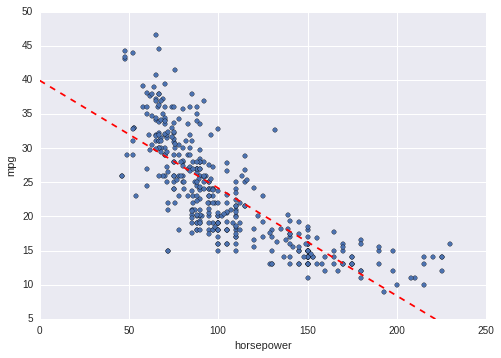

In [7]:
ax = auto.plot("horsepower", "mpg", kind="scatter")
abline(ax, lmFit, 'horsepower', color="r", ls="--")

Or using a slightly over-zealous `statsmodesl.graphics` function

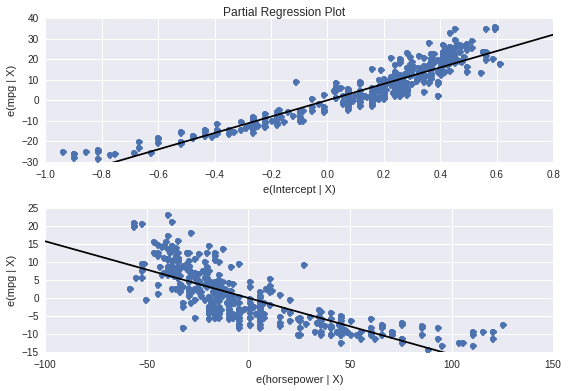

In [8]:
fig = plt.figure()
fig = sm.graphics.plot_partregress_grid(lmFit, fig=fig)

### 8.c

Here is one plot I found built in to the `statsmodels` package

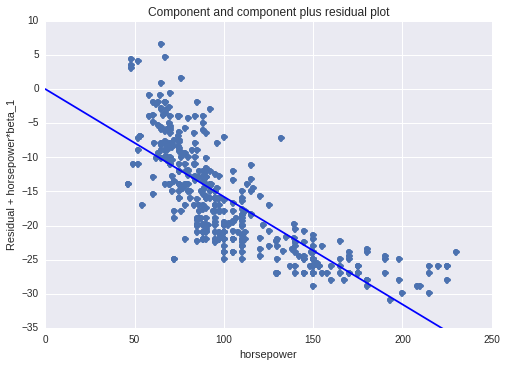

In [9]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_ccpr(lmFit, "horsepower", ax=ax)

And here is one I made

In [10]:
def resid_plot(ax, fit):
    x = fit.model.endog
    lab = fit.model.endog_names
    ax.plot(x, fit.resid, 'o', mec='k', mew=0.5)
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_title('Residuals versus {}'.format(lab), fontsize='large')
    ax.set_xlabel(lab)
    ax.set_ylabel("resid")

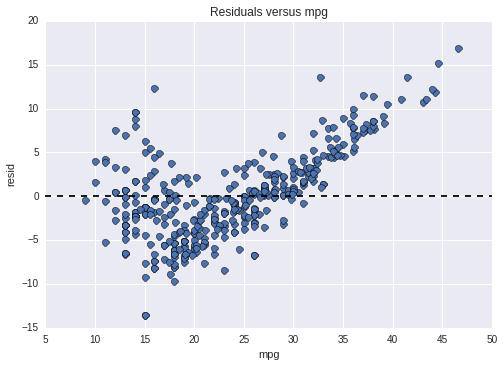

In [11]:
fig, ax = plt.subplots()
resid_plot(ax, lmFit)

Let's try and reproduce that `R` plot...

In [49]:
def studentized_residuals(l):
    return l.get_influence().resid_studentized_external

def leverage(l):
    return l.get_influence().hat_matrix_diag

def standardized_residuals(l):
    return l.resid / l.get_influence().resid_std

# subplot 1 -- resids vs fitted
def resid_plot(ax, l, studentized=False):
    x = l.model.endog
    resid = studentized_residuals(l) if studentized else l.resid
    lab = l.model.endog_names
    ax.plot(x, resid, 'o', mec='k', mew=0.5)
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_title('Residuals versus {}'.format(lab), fontsize='large')
    ax.set_xlabel(lab)
    ax.set_ylabel("resid")

# subplot 2 -- QQ
def qq_plot(ax, l, **kwargs):
    sm.qqplot(l.resid, line='r', ax=ax, **kwargs)

# subplot 3 -- scale-location
def scale_location_plot(ax, l):
    stres = scipy.sqrt(abs(standardized_residuals(l)))
    x = l.model.endog
    lab = l.model.endog_names
    ax.plot(x, stres, 'o', mec='k', mew=0.5)
    ax.axhline(y=0, color='k', linestyle='--')
    ax.set_title('Scale-Location Plot', fontsize='large')
    ax.set_xlabel(lab)
    ax.set_ylabel("sqrt(abs(standardized residuals))")

# subplot 4 -- standardized resids vs. leverage
def influence_plot(ax, l, plot_alpha=0.25, **kwargs):
    sm.graphics.influence_plot(l, ax=ax, plot_alpha=plot_alpha, **kwargs)
    maxLev = max(leverage(l))
    ax.set_xlim(0, 1.25 * maxLev)
    
# whole shebang
def r_lm_plot(l):
    f = plt.figure(figsize=(12, 12))
    
    resid_plot(f.add_subplot(221), l, studentized=True)
    qq_plot(f.add_subplot(222), l)
    scale_location_plot(f.add_subplot(223), l)
    influence_plot(f.add_subplot(224), l)

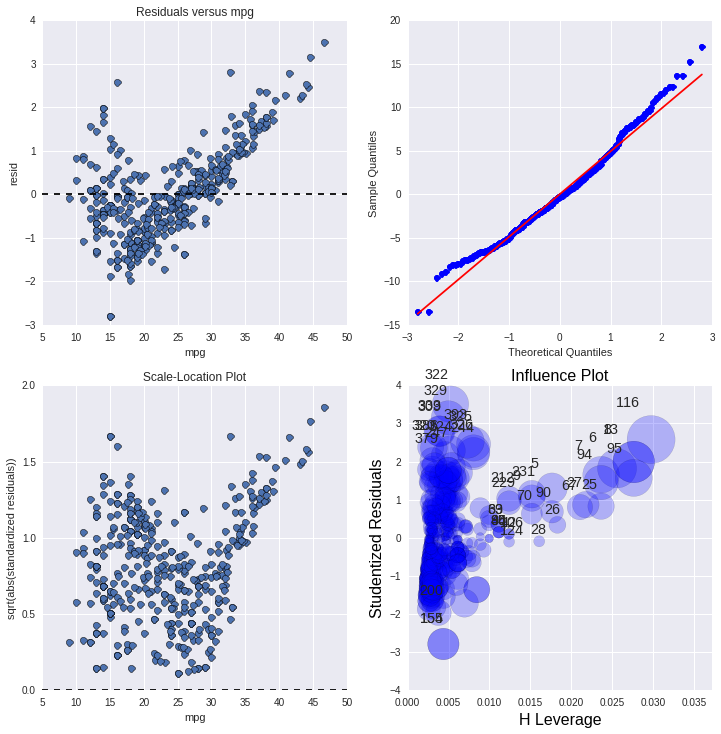

In [50]:
r_lm_plot(lmFit)